# Classification using GIST Features

## Initial Setup

In [1]:
from __future__ import division
from PIL import Image
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import gist
import imageutils

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

### Load Images into a Matrix

In [2]:
base_dir = 'square_images128_traintest'
#(X_all, y_all, classes, class_dict) = imageutils.load_data(base_dir)
(X_train, y_train, classes, class_dict) = imageutils.load_data(base_dir + '/train')
(X_test, y_test, _, _) = imageutils.load_data(base_dir + '/test')
image_height = X_train.shape[1]
image_width = X_train.shape[2]
print(X_train.shape)
print(classes)

(1020, 128, 128, 3)
['bluebell', 'buttercup', 'colts_foot', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'lily_valley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily', 'tulip', 'windflower']


### Define feature extraction functions

In [3]:
def extract_all_gist_features(X):
    num_examples = X.shape[0]
    features = []
    for index in range(num_examples):
        feature_vec = gist.extract(X[index].astype('uint8'))
        features.append(feature_vec)
    
    X_features = np.vstack(features)
    return X_features

In [4]:
def extract_gist(I):
    return gist.extract(I.astype('uint8'))

In [5]:
def tiny_image(image_array, width=16, height=16):
    I = Image.fromarray(image_array.astype('uint8'))
    I_tiny = I.resize((width, height))
    I_tiny_array = np.array(I_tiny).astype('float')
    return np.reshape(I_tiny_array, width * height * 3)

In [6]:
def color_histogram_rgb(image_array):
    h, edges = np.histogramdd(image_array.reshape(-1,3), 8, normed=True, range=[(0,255), (0,255), (0,255)])
    return h.flatten()

In [7]:
color_histogram_rgb(X_train[0]).shape

(512,)

In [8]:
def extract_features(X, feature_functions):
    num_examples = X.shape[0]
    feature_rows = []
    for index in range(num_examples):
        I = X[index]
        features = []
        for feature_func in feature_functions:
            feature_vec = feature_func(I)
            features.append(feature_vec)
        
        example_features_row_vec = np.hstack(features)
        feature_rows.append(example_features_row_vec)
    
    X_features = np.vstack(feature_rows)
    return X_features

### Extract features and concatenates them

In [12]:
from features import hog_feature, color_histogram_hsv

num_color_bins = 100 # Number of bins in the color histogram
#feature_fns = [extract_gist, hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
#feature_fns = [extract_gist, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
#feature_fns = [extract_gist]
#feature_fns = [lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
#feature_fns = [extract_gist, tiny_image]
feature_fns = [extract_gist, tiny_image, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]

X_train_features = extract_features(X_train, feature_fns)
X_test_features = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_features = np.mean(X_train_features, axis=0)
mean_features = np.expand_dims(mean_features, axis=0)
X_train_features -= mean_features
X_test_features -= mean_features

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_features = np.std(X_train_features, axis=0)
std_features = np.expand_dims(std_features, axis=0)
X_train_features /= std_features
X_test_features /= std_features

# Preprocessing: Add a bias dimension
X_train_features = np.hstack([X_train_features, np.ones((X_train_features.shape[0], 1))])
X_test_features = np.hstack([X_test_features, np.ones((X_test_features.shape[0], 1))])

print(X_train_features.shape)

(1020, 1829)


## Training models
### Naïve Bayes

In [34]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train_features, y_train).predict(X_test_features)
print('Naive Bayes accuracy on full training set: %f' % (np.mean(y_pred == y_test)))

Naive Bayes accuracy on full training set: 0.561765


In [35]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=True, random_state=None)

gnb_cv_accuracies = cross_val_score(gnb, X_train_features, y_train, cv=cv, n_jobs=7)
print('Average Naive Bayes accuracy: %f' % gnb_cv_accuracies.mean())

Average Naive Bayes accuracy: 0.505882


### Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(min_samples_split=10)
y_pred = dtc.fit(X_train_features, y_train).predict(X_test_features)
print('Decision Tree accuracy: %f' % (np.mean(y_pred == y_test)))

Decision Tree accuracy: 0.414706


In [58]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

#test_values = [2, 4, 8, 10, 12, 14, 16, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40]
test_values = [2, 4, 8, 16, 32, 64, 128, 256, 512]

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=True, random_state=None)

dtc_avg_accuracies = []
for v in test_values:
    dtc = DecisionTreeClassifier(min_samples_split=v)
    dtc_cv_accuracies = cross_val_score(dtc, X_train_features, y_train, cv=cv, n_jobs=7)
    dtc_cv_acc_mean = dtc_cv_accuracies.mean()
    dtc_avg_accuracies.append(dtc_cv_acc_mean)
    print 'Average accuracy with ' + str(v) + ' : ' + str(dtc_cv_acc_mean)
    

Average accuracy with 2 : 0.355882352941
Average accuracy with 4 : 0.36862745098
Average accuracy with 8 : 0.371568627451
Average accuracy with 16 : 0.378431372549
Average accuracy with 32 : 0.377450980392
Average accuracy with 64 : 0.367647058824
Average accuracy with 128 : 0.275490196078
Average accuracy with 256 : 0.212745098039
Average accuracy with 512 : 0.122549019608


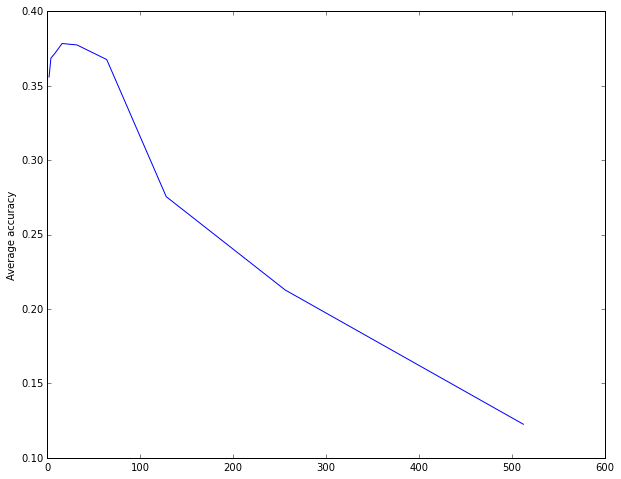

In [59]:
import matplotlib.pyplot as plt

plt.plot(test_values, dtc_avg_accuracies)
plt.ylabel('Average accuracy')
plt.show()

In [48]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=1000, min_samples_split=2, n_jobs=-1)
y_pred = rfc.fit(X_train_features, y_train).predict(X_test_features)
print('Decision Tree accuracy: %f' % (np.mean(y_pred == y_test)))

Decision Tree accuracy: 0.714706


In [52]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

test_values = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=True, random_state=None)

rfc_avg_accuracies = []
for v in test_values:
    rfc = RandomForestClassifier(n_estimators=v, min_samples_split=2, n_jobs=-1)
    rfc_cv_accuracies = cross_val_score(rfc, X_train_features, y_train, cv=cv, n_jobs=7)
    rfc_cv_acc_mean = rfc_cv_accuracies.mean()
    rfc_avg_accuracies.append(rfc_cv_acc_mean)
    print 'Average accuracy with ' + str(v) + ' : ' + str(rfc_cv_acc_mean)
    

Average accuracy with 1 : 0.280392156863
Average accuracy with 2 : 0.275490196078
Average accuracy with 4 : 0.336274509804
Average accuracy with 8 : 0.423529411765
Average accuracy with 16 : 0.479411764706
Average accuracy with 32 : 0.536274509804
Average accuracy with 64 : 0.571568627451
Average accuracy with 128 : 0.598039215686
Average accuracy with 256 : 0.602941176471
Average accuracy with 512 : 0.616666666667
Average accuracy with 1024 : 0.617647058824
Average accuracy with 2048 : 0.616666666667


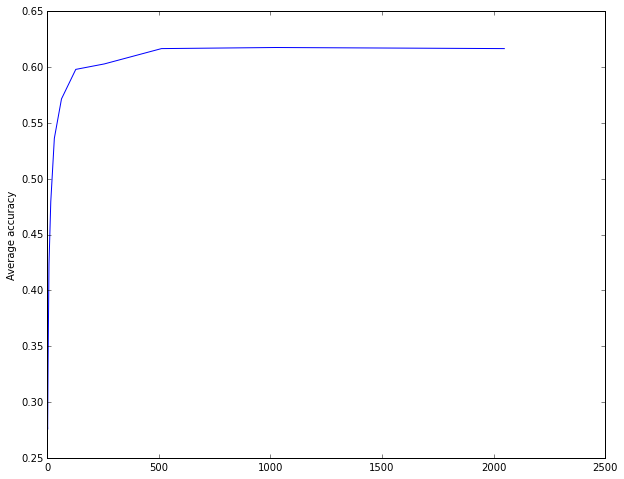

In [54]:
import matplotlib.pyplot as plt

plt.plot(test_values, rfc_avg_accuracies)
plt.ylabel('Average accuracy')
plt.show()

In [11]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', class_weight='auto')
svm.fit(X_train_features, y_train)

y_pred = svm.predict(X_test_features)
print('SVM accuracy: %f' % (np.mean(y_pred == y_test)))

accuracy: 0.708824


In [ ]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

num_examples = X_train_features.shape[0]
cv = KFold(num_examples, n_folds=10, shuffle=True, random_state=None)

svm_cv_accuracies = cross_val_score(svm, X_train_features, y_train, cv=cv, n_jobs=7)
print(svm_cv_accuracies)